In [1]:
import os, glob
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import numpy as np
import numpy.random as rand
import cv2 as cv
import warnings as warn
import pandas as pd
import skimage.measure as meas
from keras import backend as K, preprocessing, \
                  models, layers, optimizers, \
                  utils, callbacks, initializers, \
                  activations, regularizers, applications, \
                  constraints, engine
from numpy import linalg as la, random as rand
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import model_selection
from sklearn import preprocessing as spre
from tqdm import tnrange, tqdm_notebook as tqdm
from keras_tqdm import TQDMNotebookCallback as ktqdm
from jupyterthemes import jtplot

Using TensorFlow backend.


In [2]:
jtplot.reset()
plt.style.use("bmh")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

In [3]:
class StopOnValue(callbacks.Callback):
    def __init__(self, 
                 monitor='val_loss', 
                 value=0.00001, 
                 mode='min',
                 verbose=0):
        super(callbacks.Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        self.mode = mode
        if self.mode == 'min':
            self.compare_op = np.less
        elif self.mode == 'max':
            self.compare_op = np.greater
    
    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn('Early stopping requires %s available!' % self.monitor, RuntimeWarning)
            
        if self.compare_op(current, self.value):
            if self.verbose > 0:
                print('Epoch %05d: early stopping THR' % epoch)
            self.model.stop_training = True
            
            
class AdaBound(optimizers.Optimizer):
    def __init__(self,
                 lr=0.001,
                 final_lr=0.1,
                 beta_1=0.9,
                 beta_2=0.999,
                 gamma=1e-3,
                 epsilon=None,
                 decay=0.,
                 amsbound=False,
                 weight_decay=0.,
                 **kwargs):
        """
        Keras port [1] of AdaBound Optimizer for PyTorch [2], from the paper 
        Adaptive Gradient Methods with Dynamic Bound of Learning Rate [3].
        
        AdaBound optimizer.
        
        Default parameters follow those provided in the original paper.
        # Arguments
            lr: float >= 0. Learning rate.
            final_lr: float >= 0. Final learning rate.
            beta_1: float, 0 < beta < 1. Generally close to 1.
            beta_2: float, 0 < beta < 1. Generally close to 1.
            gamma: float >= 0. Convergence speed of the bound function.
            epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
            decay: float >= 0. Learning rate decay over each update.
            weight_decay: Weight decay weight.
            amsbound: boolean. Whether to apply the AMSBound variant of this
                algorithm.
        
        [1] Majumdar, S. keras-adabound, 2019. https://github.com/titu1994/keras-adabound.
        [2] Luo, L. AdaBound, 2019. https://github.com/Luolc/AdaBound.
        [3] Luo, L., Yuanhao, X., Yan, L., and Xu, S. Adaptive gradient methods with dynamic
            bound of learning rate. International Conference on LEarning Representations, 2019.
            https://openreview.net/forum?id=Bkg3g2R9FX.
        """
        super(AdaBound, self).__init__(**kwargs)
        
        if not 0. < gamma <= 1.:
            raise ValueError('Invalid `gamma` parameter. Must lie in [0, 1] range.')
            
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            
        self.final_lr = final_lr
        self.gamma = gamma
        
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsbound = amsbound

        self.weight_decay = float(weight_decay)
        self.base_lr = float(lr)
        
        
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        # Applies bounds on actual learning rate
        step_size = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                          (1. - K.pow(self.beta_1, t)))

        final_lr = self.final_lr * lr / self.base_lr
        lower_bound = final_lr * (1. - 1. / (self.gamma * t + 1.))
        upper_bound = final_lr * (1. + 1. / (self.gamma * t))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        if self.amsbound:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]
        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            # apply weight decay
            if self.weight_decay != 0.:
                g += self.weight_decay * K.stop_gradient(p)

            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            if self.amsbound:
                vhat_t = K.maximum(vhat, v_t)
                denom = (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                denom = (K.sqrt(v_t) + self.epsilon)

            # Compute the bounds
            step_size_p = step_size * K.ones_like(denom)
            step_size_p_bound = step_size_p / denom
            bounded_lr_t = m_t * K.minimum(K.maximum(step_size_p_bound,
                                                     lower_bound), upper_bound)

            p_t = p - bounded_lr_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates
    
    
    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'final_lr': float(self.final_lr),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'gamma': float(self.gamma),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'weight_decay': self.weight_decay,
                  'amsbound': self.amsbound}
        base_config = super(AdaBound, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    

def l2loss(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.nn.l2_loss(y_pred - y_true)

def l1loss(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.losses.absolute_difference(y_true, y_pred)

def tvloss(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.reduce_sum(tf.image.total_variation(y_true - y_pred))

def psnr(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:])
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def tv(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.reduce_sum(tf.image.total_variation(y_true - y_pred))

def shannonEntropy2D(img, base=2):       
    img_grad = np.asarray(np.gradient(img)).T
    img_grad /= img_grad.max()
    img_grad = np.uint8(img_grad * 255)
    hist = np.squeeze(cv.calcHist([img_grad], [0, 1], None, [256, 256], [0, 256, 0, 256]))
    hist /= img_grad.size
    with warn.catch_warnings():
        warn.simplefilter('ignore')
        if base == 2:
            log = np.log2
        elif base == 10:
            log = np.log10
        elif base == 'e':
            log = np.log
        H = -1/2 * np.nansum(hist*log(hist))
    return H

In [4]:
traindir = 'D:/Kenneth/Documents/VIP/Datasets/cat-and-dog/TRAIN/'
testdir = 'D:/Kenneth/Documents/VIP/Datasets/cat-and-dog/TEST/'
img_w, img_h, img_ch = 128, 128, 3

In [5]:
filenames = os.listdir(traindir)
categories = []
for f in filenames:
    category = f.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
        
df = pd.DataFrame({'filename': filenames,
                   'category': categories})
df['category'] = df['category'].replace({0: 'cat', 
                                         1: 'dog'})

In [14]:
train_df, val_df = model_selection.train_test_split(df, test_size=0.2, random_state=401)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_val = val_df.shape[0]
batch_size = 200
epochs = int(1e6)

In [15]:
train_datagen = preprocessing.image.ImageDataGenerator(rescale=1/255,
                                                       rotation_range=15,
                                                       shear_range=0.1,
                                                       zoom_range=0.2,
                                                       horizontal_flip=True,
                                                       width_shift_range=0.1,
                                                       height_shift_range=0.1)
train_gen = train_datagen.flow_from_dataframe(train_df,
                                              traindir,
                                              x_col='filename',
                                              y_col='category',
                                              target_size=(img_w, img_h),
                                              batch_size=batch_size,
                                              class_mode='categorical')

Found 6404 validated image filenames belonging to 2 classes.


In [16]:
val_datagen = preprocessing.image.ImageDataGenerator(rescale=1/255)
val_gen = val_datagen.flow_from_dataframe(val_df,
                                          traindir,
                                          x_col='filename',
                                          y_col='category',
                                          target_size=(img_w, img_h),
                                          batch_size=batch_size,
                                          class_mode='categorical')

Found 1601 validated image filenames belonging to 2 classes.


In [17]:
model = models.Sequential()

model.add(layers.InputLayer(input_shape=(img_w, img_h, img_ch)))

for i, f in enumerate([32, 64, 128]):
    model.add(layers.Conv2D(filters=f, 
                            kernel_size=(3, 3),
                            activation='relu',
                            name='layer%s_conv' %str(i+1)))
    model.add(layers.BatchNormalization(name='layer%s_batchnorm' %str(i+1)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),
                                  name='layer%s_maxpool' %str(i+1)))
    model.add(layers.Dropout(0.25,
                             name='layer%s_dropout' %str(i+1)))
    
model.add(layers.Flatten(name='clf_flatten'))
model.add(layers.Dense(units=512,
                       activation='relu',
                       name='clf_fc1'))
model.add(layers.BatchNormalization(name='clf_batchnorm'))
model.add(layers.Dropout(0.5,
                         name='clf_dropout'))
model.add(layers.Dense(2,
                       activation='softmax',
                       name='clf_fc2'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1_conv (Conv2D)         (None, 126, 126, 32)      896       
_________________________________________________________________
layer1_batchnorm (BatchNorma (None, 126, 126, 32)      128       
_________________________________________________________________
layer1_maxpool (MaxPooling2D (None, 63, 63, 32)        0         
_________________________________________________________________
layer1_dropout (Dropout)     (None, 63, 63, 32)        0         
_________________________________________________________________
layer2_conv (Conv2D)         (None, 61, 61, 64)        18496     
_________________________________________________________________
layer2_batchnorm (BatchNorma (None, 61, 61, 64)        256       
_________________________________________________________________
layer2_maxpool (MaxPooling2D (None, 30, 30, 64)        0         
__________

In [18]:
stopval = StopOnValue(monitor='val_loss',
                      value=0.1,
                      mode='min')

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [20]:
history = model.fit_generator(train_gen,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=total_val//batch_size,
                              steps_per_epoch=total_train//batch_size,
                              callbacks=[ktqdm(), stopval],
                              verbose=0)

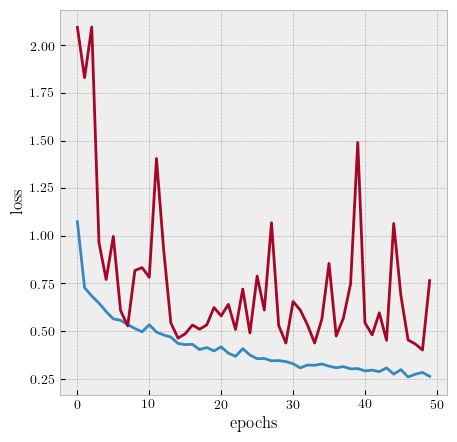

In [21]:
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [22]:
model.save('catdog.model')
model.save_weights('catdog.h5')